In [520]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
import math

### File Read

In [521]:
# Some work to read .MAT file in Python

# Please place file in the same folder as this notebook
data = loadmat(r"QSAR_data(1).mat")
data = data["QSAR_data"]
qsar_data = np.array(data) # We now have our data as a numpy array which we can work with
print("Dimensions of the array are", qsar_data.shape) 

Dimensions of the array are (1055, 42)


## Data Processing and Visualistation


<function matplotlib.pyplot.show(close=None, block=None)>

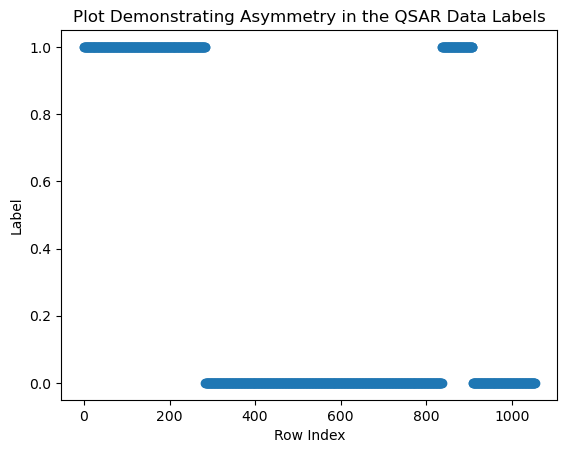

In [522]:
plt.scatter(np.arange(1055),qsar_data[:,41])
plt.xlabel("Row Index")
plt.ylabel("Label")
plt.title('Plot Demonstrating Asymmetry in the QSAR Data Labels')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

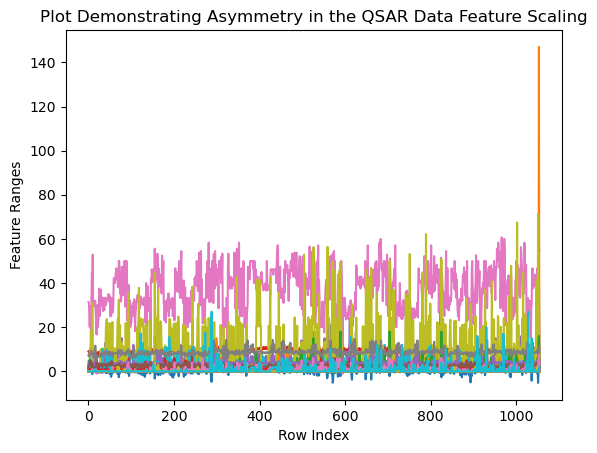

In [523]:
plt.plot(qsar_data[:,1:41])
plt.xlabel("Row Index")
plt.ylabel("Feature Ranges")
plt.title('Plot Demonstrating Asymmetry in the QSAR Data Feature Scaling')
plt.show

In [524]:
# Looking at the data and the labels, it is required to shuffle the data so that we have a more even distribution of labels, seeding numpy random for result reproducability
np.random.seed(1)
np.random.shuffle(qsar_data)

### Principal Component Analysis

In [525]:
# We will pre-process the data by performing principal component analysis on it
# before we do that let's split the labels and features

labels = qsar_data[:,41]
feat = qsar_data[:,0:41]

std_ft = (feat - feat.mean(0)) / feat.std(0) # this piece of code standardises the data to normalise feature scaling

cov_mat = np.cov(std_ft.T) # creating a 41x41 covariance matrix for the features

eig_val, eig_vec = np.linalg.eigh(cov_mat) # computing eigenvalues

srt_ord = np.argsort(eig_val)[::-1] # determining the sort order

# now sorting the data

srt_eig_val = eig_val[srt_ord] 
srt_eig_vec = eig_vec[:,srt_ord] 

# we now will calculate how much each principal component explains the variation in the data

expl_var = srt_eig_val / np.sum(srt_eig_val)

# we now finally reduce the dimensionality of the data

dim2_dat = np.matmul(std_ft, srt_eig_vec[:,:2]) # our data in 2 dimensions
dim2_explvar = np.sum(expl_var[:2])

dim3_dat = np.matmul(std_ft, srt_eig_vec[:,:3]) # our data in 3 dimensions
dim3_explvar = np.sum(expl_var[:3])

Using 2 principal components roughly  30.3 % of the total variation in the data was captured


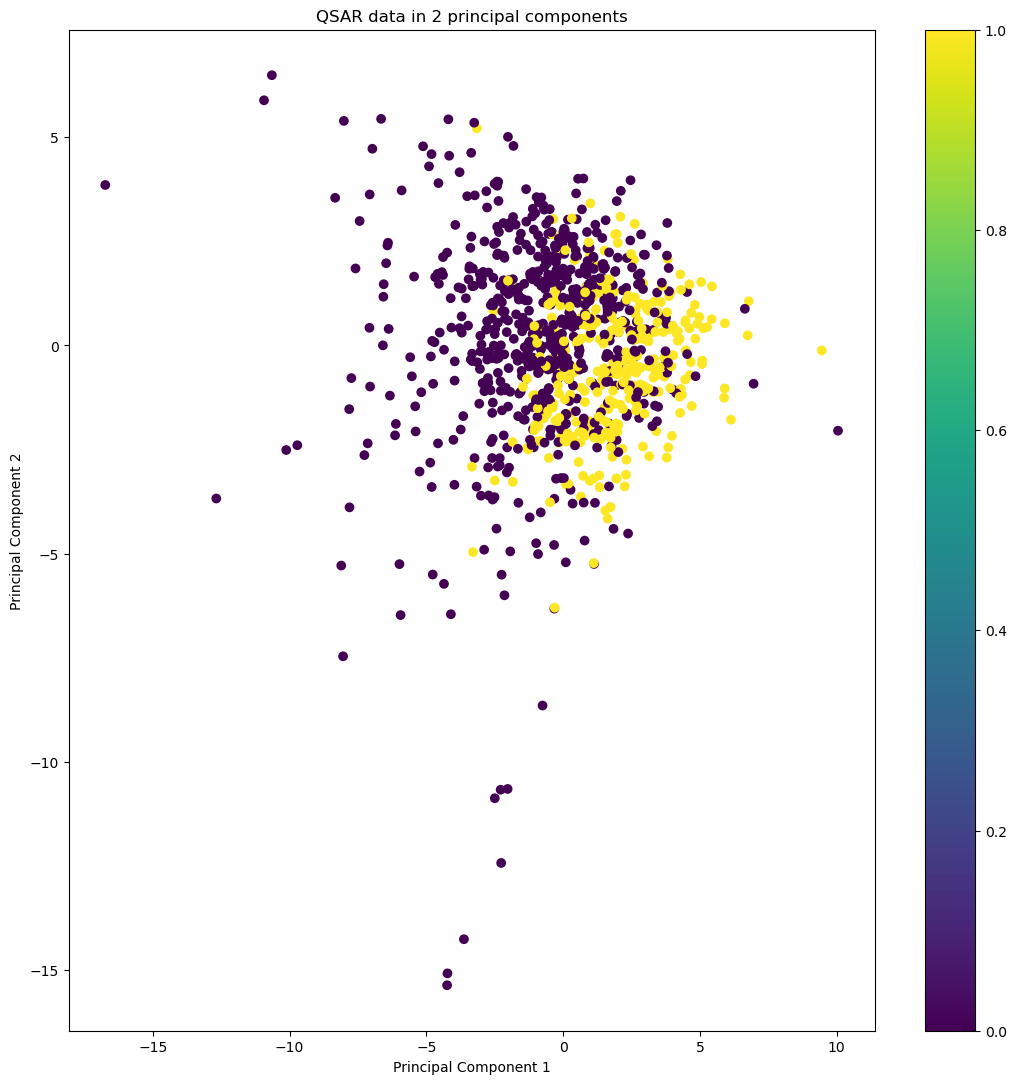

In [526]:
# now we will try to visualise our data in 2 principal components

c2_1 = dim2_dat[:,0]
c2_2 = dim2_dat[:,1]

fig1 = plt.figure(figsize=(13,13))
plt.scatter(c2_1,c2_2, c=labels)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.title('QSAR data in 2 principal components')
plt.show

print('Using 2 principal components roughly ', np.round(dim2_explvar*100, 1),'% of the total variation in the data was captured')

Using 3 principal components roughly  41.4 % of the total variation in the data was captured


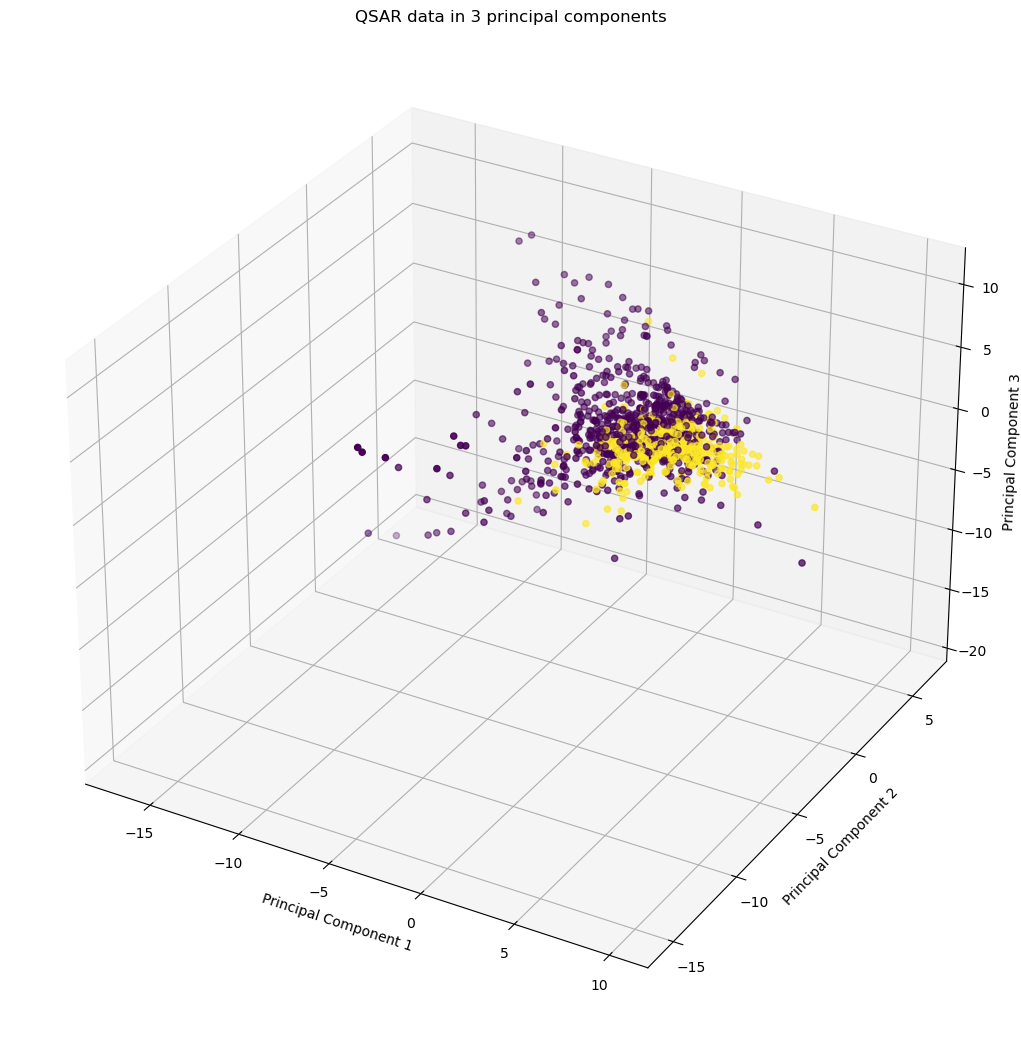

In [527]:
# Now we will visualise our data in 3 dimensions

fig2 = plt.figure(figsize=(13,13))
ax = fig2.add_subplot(projection='3d')

c3_1 = dim3_dat[:,0]
c3_2 = dim3_dat[:,1]
c3_3 = dim3_dat[:,2]

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title('QSAR data in 3 principal components')
ax.scatter(c3_1, c3_2, c3_3, c=labels)

print('Using 3 principal components roughly ', np.round(dim3_explvar*100, 1),'% of the total variation in the data was captured')


The total explained variance at, 12 principal components is: 77.4


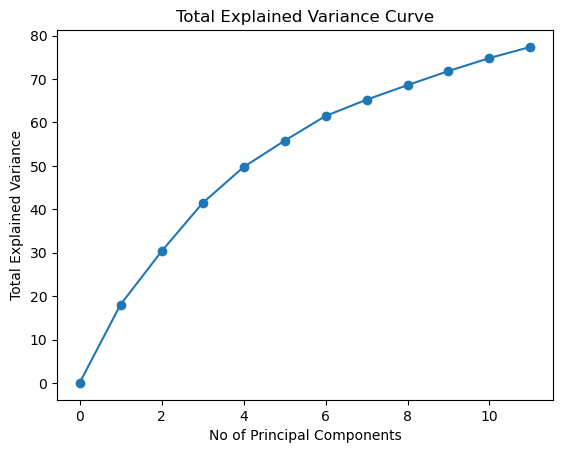

In [528]:
# We will now plot the explained variance vs the number of principal components 

n_pc = 12 # this value can be changed to see my reasoning behind why I chose 12 principal components, at 12 we captured more than 75% of the variance in the data which I thought was good enough

t_expl_var = np.zeros(n_pc) # defining an array to store values

for component in range(n_pc):
    t_expl_var[component] = np.sum(expl_var[:component])*100

plt.plot(t_expl_var, marker='o')
plt.xlabel("No of Principal Components")
plt.ylabel("Total Explained Variance")
plt.title('Total Explained Variance Curve')
plt.show

print('The total explained variance at,', n_pc,'principal components is:', np.round(t_expl_var[-1],1))

In [529]:
# Again I judged a total explained variance level above 75% to be good enough to represent the data which is why we will train our model using only 12 of these principal components

pca_data = np.matmul(std_ft, srt_eig_vec[:,:n_pc])

print('Feature Matrix Dimensions: ', pca_data.shape)

# Also appending back the labels in the data

pca_data = np.append(pca_data, np.array([labels]).T, 1)

print('Feature Matrix Dimensions with Labels: ', pca_data.shape)

Feature Matrix Dimensions:  (1055, 12)
Feature Matrix Dimensions with Labels:  (1055, 13)


## Kth Fold Generation

In [530]:
# Cutting the data in K-Folds, conveniently the data has 1055 compounds and the prime factors of 1055 are only 5 and 211, resulting in the only option being creating 5 folds

k_list = np.array_split(pca_data, 5, axis=0) # Splitting the dataset across rows

# I used Python dictionaries for many applications in this code and used f strings to iteratively access data, this might make readability of this code a bit challenging


k_test_dict = {}
for i in range(1,6):
    kth_var = f'k{i}_test'
    j = i - 1 # indexing is challenging since I didn't want to have a 0th k fold but this is an easy work around
    k_test_dict[kth_var] = k_list[j] # jth fold becomes a part of the testing data


k_train_dict = {}
for i in range(1,6):
    kth_var = f'k{i}_train'
    j = i - 1 # 
    k_train_dict[kth_var] = np.concatenate([o for p, o in enumerate(k_list) if p != j], axis=0) # creating this dictionary iteratively was tough :) 

# Now that we have k folds of testing data and their respective training data, we will now split the labels from the dataset which will result in 4 dictionaries
# fortunately we can re-use previous code for the same

# This is the dictionary for the LABELS of the TESTING data each key will have 844 elements
ky_test_dict = {}
for i in range(1,6):
    k_extract = f'k{i}_test'
    kth_var = f'ky{i}_test'
    j = i - 1 
    ky_test_dict[kth_var] = k_test_dict[k_extract][:,n_pc] # Extracting the data labels from the testing data

# This is the dictionary for the FEATURES of the TESTING data each key will have 844x41 elements
kx_test_dict = {}
for i in range(1,6):
    k_extract = f'k{i}_test'
    kth_var = f'kx{i}_test'
    j = i - 1
    kx_test_dict[kth_var] = k_test_dict[k_extract][:,0:n_pc] # Extracting unlabelled data for neural network input while TESTING

# This is the dictionary for the LABELS of the TRAINING data each key will have 844 elements
ky_train_dict = {}
for i in range(1,6):
    k_extract = f'k{i}_train'
    kth_var = f'ky{i}_train'
    j = i - 1
    ky_train_dict[kth_var] = k_train_dict[k_extract][:,n_pc] # Extracting the data labels from the training data

# This is the dictionary for the FEATURES of the TRAINING data each key will have 844x41 elements
kx_train_dict = {}
for i in range(1,6):
    k_extract = f'k{i}_train'
    kth_var = f'kx{i}_train'
    j = i - 1
    kx_train_dict[kth_var] = k_train_dict[k_extract][:,0:n_pc] # Extracting unlabelled data for neural network input while TRAINING

## Function Definition

In [531]:
def sigmoid(x): # sigmoid activation
    
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x): # derivative of sigmoid
    
    return x * (1 - x)

def init_wts(input_features): # initialise weights between -1 and 1
    
    wts = 2 * np.random.random((input_features,1)) - 1
    bs = 2 * np.random.random((1,1)) - 1

    return wts, bs

def predict(i, weights, biases): # generate predictions / feedforward
    
    prediction = sigmoid(np.dot(i, weights) + biases)

    return prediction

def update_weights(o, predictions, weights, biases, i, alpha): # weight adjustment of the perceptron / backpropagation

    loss = o - predictions
    adjustments = loss * sigmoid_derivative(predictions)
    weights += alpha * np.dot(i.T, adjustments)
    biases += alpha * np.sum(adjustments,0)

    return weights, biases, loss

def iterate(inputs, outputs, wts, b, learning_rate): # just a function to combine everything above into 1

    prediction = predict(inputs, wts, b)
    wts, b, l = update_weights(outputs,prediction,wts,b,inputs, learning_rate)
    
    return wts, b, l, prediction


The following section is where you can change parameters such as kth_fold,  and hyperparameters like learning rate and n_epochs to check why I selected those specific ones 

In [532]:
np.random.seed(1) # seeding for reproducability

kth_fold = 1 # enter the kth_fold to be analysed, range (1-5)
inputs = kx_train_dict[f'kx{kth_fold}_train'] # input data set
labels = np.array([ky_train_dict[f'ky{kth_fold}_train']]).T # data labels
alpha = 0.01 # defining our learning rate alpha
n_epochs = 100 # defining number of epochs
n_features = n_pc # no of features = no of principal components, assignment done for readability 
wts, b = init_wts(n_features) # initialising weights and biases
mse_mat = np.zeros(n_epochs) # initialising a list to store training mse


## Training

In [533]:
for epoch in range(n_epochs): # perform the iteration below n_epoch times

    wts, b, l, prediction = iterate(inputs, labels, wts, b, alpha) # perform 1 iteration of generating prediction and then updating weights accordingly

    mse_mat[epoch] = np.mean(np.square(l))  # storing the training mse

## Performance Analysis

Final MSE after Training: 0.11


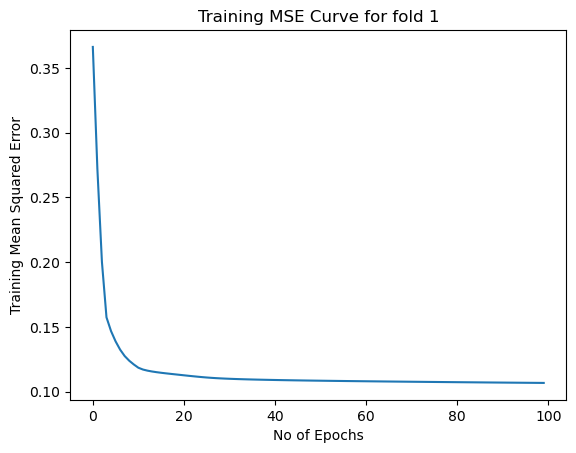

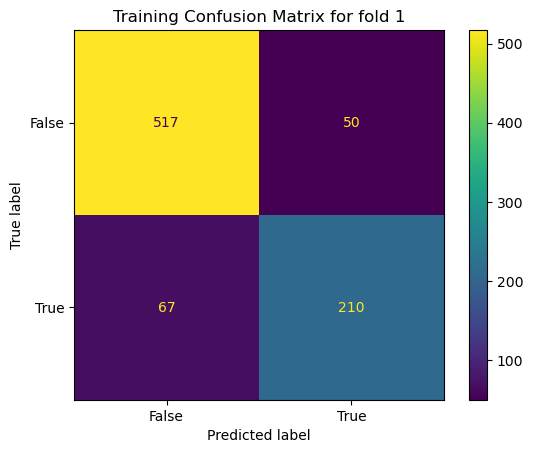

Here are the performance metrics on the training data for fold 1: 

Model Prediction Accuracy: 0.86
Model Sensitivity: 0.76
Model Specificity: 0.91


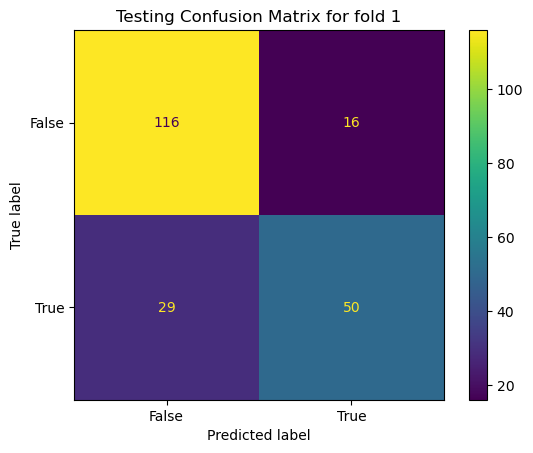

Here are the performance metrics on the unseen testing data for fold 1: 

Model Prediction Accuracy: 0.79
Model Sensitivity: 0.63
Model Specificity: 0.88


In [534]:
plt.plot(mse_mat)
plt.xlabel("No of Epochs")
plt.ylabel("Training Mean Squared Error")
plt.title(f'Training MSE Curve for fold {kth_fold}')
plt.show

print('Final MSE after Training:', np.round(mse_mat[n_epochs-1],2)) # this line and above plots the mse we stored earlier

f_prediction = np.round(prediction) # this line just rounds the prediction to the nearest integer resulting in 0 or 1

con_mat = metrics.confusion_matrix(labels, f_prediction)
cm_show = metrics.ConfusionMatrixDisplay(con_mat, display_labels = [False, True])
cm_show.plot()
plt.title(f'Training Confusion Matrix for fold {kth_fold}')
plt.show()

print(f'Here are the performance metrics on the training data for fold {kth_fold}: \n')

accuracy = metrics.accuracy_score(labels, f_prediction)

print('Model Prediction Accuracy:', np.round(accuracy,2))

sensitivity = metrics.recall_score(labels, f_prediction)

print('Model Sensitivity:', np.round(sensitivity,2))

specificity = metrics.recall_score(labels, f_prediction, pos_label=0)

print('Model Specificity:', np.round(specificity,2)) # this line and above uses the sklearn package and matplotlib packages to plot the confusion matrix and compute performance metrics

##

# This block generates predictions for the unseen feature data for this fold

test_input = kx_test_dict[f'kx{kth_fold}_test']
test_labels = ky_test_dict[f'ky{kth_fold}_test']
prediction = predict(test_input, wts, b)

##

f_prediction = np.round(prediction)

con_mat = metrics.confusion_matrix(test_labels, f_prediction)
cm_show = metrics.ConfusionMatrixDisplay(con_mat, display_labels = [False, True])
cm_show.plot()
plt.title(f'Testing Confusion Matrix for fold {kth_fold}')
plt.show()

print(f'Here are the performance metrics on the unseen testing data for fold {kth_fold}: \n')

accuracy = metrics.accuracy_score(test_labels, f_prediction)

print('Model Prediction Accuracy:', np.round(accuracy,2))

sensitivity = metrics.recall_score(test_labels, f_prediction)

print('Model Sensitivity:', np.round(sensitivity,2))

specificity = metrics.recall_score(test_labels, f_prediction, pos_label=0)

print('Model Specificity:', np.round(specificity,2)) # computing performance metrics again